In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


Question 1.1: Linear Regression by gradient descent

In [ ]:
path = '../Week2_data/train_data.txt'

data = pd.read_csv(path, header = None, names =['Size', 'Bedrooms', 'Price'])
data.head()
data.describe()

data

Gradient Descent

In [122]:
def h(X, theta):

    return X @ theta.T

def cost_function(X, y, theta):
    inner = (h(X, theta) - y) ** 2

    return np.sum(inner) / (2 * X.shape[0])
    #return np.sum(np.power((h(X, theta) - y), 2)) / (2 * X.shape[0])

def gradient_descent(X, y, alpha, epoch):
    #theta = np.zeros((3, 1))
    theta = np.random.random(size = (1, 3))
    cost = np.zeros(epoch)
    for i in range(epoch):
        partial_theta = np.sum((h(X, theta) - y) * X, axis = 0)
        theta = theta - (alpha / X.shape[0]) * partial_theta
        cost[i] = cost_function(X, y, theta)
    return theta, cost

def plot_cost(cost, epoch):
    plt.plot(np.arange(epoch), cost, label = 'cost', color = 'r')
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.title('cost-iteration diagram')
    plt.legend()

In [ ]:
def get_train_data(data):
    train_X = data.iloc[:, 0 : 2]
    train_y = data.iloc[:, 2]

    train_X = np.array(train_X)
    train_y = np.array(train_y)
    train_y = np.reshape(train_y, (data.shape[0], 1))

    return train_X, train_y

train_X, train_y = get_train_data(data)

train_X, train_y

In [ ]:
std = StandardScaler()
std_X = std.fit_transform(train_X)
std_X = np.column_stack([np.ones((std_X.shape[0], 1)), std_X])

train_X = std.fit_transform(train_X)

train_X

In [ ]:
train_y = std.fit_transform(train_y)

train_y

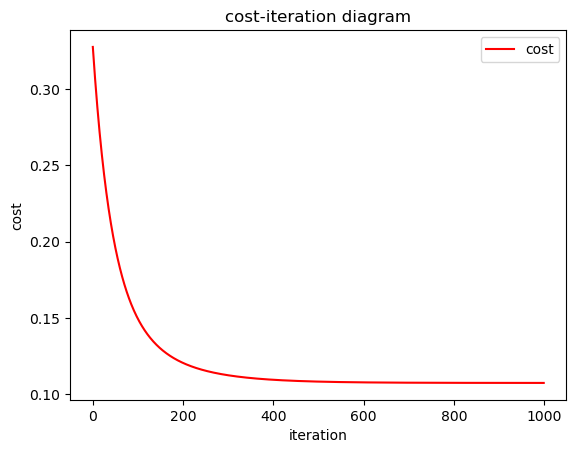

In [126]:
theta, cost_g = gradient_descent(std_X, train_y, alpha = 0.01, epoch = 1000)

plot_cost(cost_g, 1000)

Q1.2: Linear Regression through normal equation

In [ ]:
def normal_equation(X, y):
    X = np.matrix(X)
    y = np.matrix(y)

    return (X.T @ X).I @ X.T @ y


nor_theta = normal_equation(std_X, train_y)
nor_theta

Following program is to check the performance of normal equation w.r.t gradient descent

In [128]:
cost_nor = np.sum(np.power((std_X @ nor_theta) - train_y, 2), axis = 0) / (2 * std_X.shape[0])

cost_nor.mean()

0.10730467194966786

From what have been calculated above, I set the mean value of the cost matrix as their performance indicator to evaluate the effect of normal equation and gradient descent.

  It is shown that normal equation's mean cost value is 0.1073 approximately, while gradient descent is 0.1291 approximately. Means that gradient is not convergent enough with learning rate value 0.01.

Q1.3 Linear Regression through sci-kit learn package

Following program implement multi-variable Linear Regression using sklearn. To show the performance of the model, I take sklearn's own score function as a performance indicator. The score calculate formula is shown below:
- $score = (1 - \frac{u}{v})$
- in which u denote the residual sum of squares((y_true - y_pred) ** 2).sum()
- v denote the sum of squares((y_true - y_true.mean()) ** 2).sum()

According to the description in the official document, the best score should be 1.0 and it can be negative

In [129]:
test_path = '../Week2_data/test_data.txt'
test = pd.read_csv(test_path)

std = StandardScaler()
test_X = test.iloc[:, 0 : 2]
test_y = test.iloc[:, 2]

test_X = np.array(test_X)
test_y = np.array(test_y).reshape((test.shape[0], 1))

test_X = std.fit_transform(test_X)
test_X = np.column_stack([np.ones((test_X.shape[0], 1)), test_X])
test_y = std.fit_transform(test_y)

In [130]:
def sk_train(train_X, train_y, test_X, test_y):

    model = LinearRegression()
    model.fit(train_X, train_y)

    return model.score(test_X, test_y)

In [ ]:
score = sk_train(train_X, train_y, test_X, test_y)

score

After performing a LinearRegression of sklearn, I get a score value of model 0.8319, which is acceptable.

Q2.1 Implementing Polynomial Linear Regression with sklearn

Taking four polynomial order to test their performance

In [ ]:
index = [1, 2, 3, 4]
best_score = -1
best_index = 0

std_X

Polynomial Features not only interaction

In [ ]:
for i in index:
    poly = PolynomialFeatures(degree = i)
    poly_X = poly.fit_transform(std_X)
    poly_test_X = poly.fit_transform(test_X)
    score = sk_train(poly_X, train_y, poly_test_X, test_y)
    if score > best_score:
        best_score = score
        best_index = i

best_index, best_score

After operation above, testing four kind of polynomial feature, it can be concluded that qudratic form is the most efficient among four of them

Q2.2 Some discussion about regularization

First I need output all result of above four kind of polynomial features to find out the tendency of cost function value with respect to polynomial index

In [ ]:
performance = []

for i in index:
    poly = PolynomialFeatures(degree = i)
    poly_X = poly.fit_transform(std_X)
    poly_test_X = poly.fit_transform(test_X)
    score = sk_train(poly_X, train_y, poly_test_X, test_y)
    performance.append(score)

plt.figure()
plt.plot(np.arange(4), performance)
plt.show()

It is obvious that when it comes to fourth-order polynomial, the score of the model decrease intensively, which means that it has a bad predict on test set. However, the score is only get from the test set, the performance on training set is still unknown

In [ ]:
train_perform = []

for i in index:
    poly = PolynomialFeatures(degree = i)
    poly_X = poly.fit_transform(std_X)
    poly_test_X = poly.fit_transform(test_X)
    model = LinearRegression()
    model.fit(poly_X, train_y)
    train_perform.append(model.score(poly_X, train_y))

plt.figure()
plt.plot(np.arange(4), train_perform)
plt.show()

Nevertheless, the effect on training set of fourth-order is extremely outperforming than any other orders. Somehow, this best training set performing model have the worst ability on test set, which is called over-fit.

To solve above problem, a regularization operator can be applied to Linear Regression model
- I use Ridge class of sklearn to implement the regularization, given lambda 1.0
- This class is provided to perform l2-norm regularization and the loss function is the linear least squares function
- The Regularized Linear Regression's loss function is given below:
        $J(\theta) = \frac{1}{2m}\sum_{i = 1}^m[h_{\theta}(x^{(i)}) - y^{(i)}]^2 + \lambda\sum_{j = 1}^n\theta_j^2$

In [ ]:
from sklearn.linear_model import Ridge
train_perform = []
test_perform = []

for i in index:
    poly = PolynomialFeatures(degree = i)
    poly_X = poly.fit_transform(std_X)
    poly_test_X = poly.fit_transform(test_X)
    model = Ridge(alpha = 1.0)
    model.fit(poly_X, train_y)
    train_perform.append(model.score(poly_X, train_y))
    test_perform.append(model.score(poly_test_X, test_y))

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(np.arange(4), test_perform)
plt.title('testing set performance')
plt.subplot(1, 2, 2)
plt.plot(np.arange(4), train_perform)
plt.title('training set performance')
plt.show()

The decrease performance of fourth-order polynomial on the test set is greatly eliminate by regularization leading to a result an approximately 0.79 score while non-regularize model have a negative value.

Q3 Comparing sklearn Linear Regression and my Linear Regression

In [ ]:
model = LinearRegression()
model.fit(std_X, train_y)
y_pred_sk = model.predict(test_X)
cost_sk = (test_y - y_pred_sk) ** 2 / 2

cost_sk

In [ ]:
y_pred_theta = test_X @ theta.T
cost_gradient = (test_y - y_pred_theta) ** 2 / 2

cost_gradient

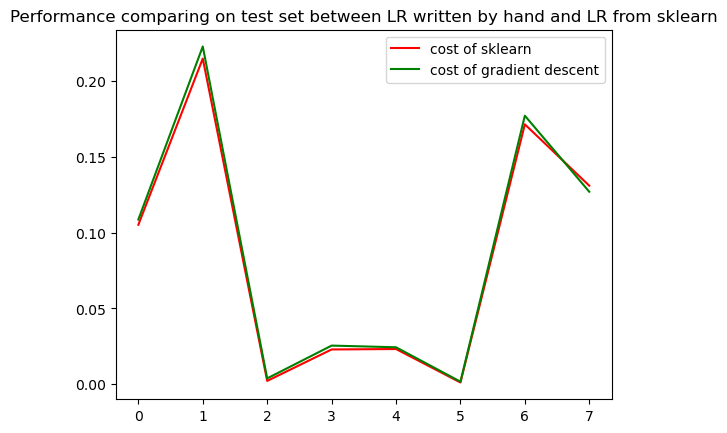

In [132]:
plt.figure()
plt.plot(np.arange(8), cost_sk, label = 'cost of sklearn', color = 'r')
plt.plot(np.arange(8), cost_gradient, label = 'cost of gradient descent', color = 'green')
plt.legend()
plt.title('Performance comparing on test set between LR written by hand and LR from sklearn')
plt.show()

It is clear shown that LR written by myself is quite similar to LR provided by sklearn